In [14]:
from random import random
import numpy as np
import trace_gen as tg # source code at: https://github.com/Effygal/trace-gen
import matplotlib.pyplot as plt
import heapq
import seaborn as sns
import pandas as pd
import itertools
from matplotlib.lines import Line2D
import matplotlib.ticker as ticker
from matplotlib.legend_handler import HandlerTuple
from matplotlib.ticker import ScalarFormatter
sns.set_theme(style="whitegrid", palette="deep")
palette = sns.color_palette("deep")
plt.rcParams['pdf.fonttype'] = 42 
plt.rcParams['ps.fonttype'] = 42 
plt.rcParams['image.cmap'] = 'viridis'
plt.rcParams['text.usetex']  = False
palette = sns.color_palette("deep")
sns.set_theme(style="whitegrid", palette="deep")
np.random.seed(44)

In [6]:
def sim_clock(trace, cnt):
    M = len(set(trace))
    K = M // 20
    c = np.arange(2, M+1, K)
    hr_clock = [tg.sim_clock(int(_c), trace, raw=True, K=cnt) for _c in c]
    return c, hr_clock

def sim_ran_clock(trace, cnt):
    M = len(set(trace))
    K = M // 20
    c = np.arange(2, M+1, K)
    hr_ran_clock = [tg.sim_ran_clock(int(_c), trace, raw=False, K=cnt) for _c in c]
    return c, hr_ran_clock

def sim_fifo_m(trace):
    M = len(set(trace))
    K = M // 20
    c = np.arange(2, M+1, K)
    hr_fifo_m = [tg.sim_fifo_m([int(s)//2, int(s) - int(s)//2], trace, raw=False) for s in c] 
    return c, hr_fifo_m

def sim_rand_m(trace):
    M = len(set(trace))
    K = M // 20
    c = np.arange(2, M+1, K)
    hr_rand_m = [tg.sim_rand_m([int(s)//2, int(s) - int(s)//2], trace, raw=False) for s in c] 
    return c, hr_rand_m

def sim_sieve(trace, cnt):
    M = len(set(trace))
    K = M // 20
    c = np.arange(2, M+1, K)
    hr_sieve = [tg.sim_sieve(int(_c), trace, raw=False, K=cnt) for _c in c]
    return c, hr_sieve

def sim_lru(trace):
    M = len(set(trace))
    K = M // 20
    c = np.arange(2, M, K)
    hr_lru = [tg.sim_lru(int(_c), trace, raw=False) for _c in c]
    return c, hr_lru

def sim_fifo(trace):
    M = len(set(trace))
    K = M // 20
    c = np.arange(2, M, K)
    hr_fifo = [tg.sim_fifo(int(_c), trace, raw=False) for _c in c]
    return c, hr_fifo

def gen_from_zipf(M, n, a):
    p = 1.0 / np.power(np.arange(1, M + 1), a)
    p = p / p.sum()
    return p, np.random.choice(M, size=n, p=p)

In [3]:
def gen_ph(m, theta, length):
    p = 1.0 / np.power(np.arange(1, m + 1), theta)
    p = p / p.sum()
    cp = np.cumsum(p)
    t = p.copy()
    phases = np.searchsorted(cp, np.random.random(m), side="right")
    next_times = np.random.exponential(1.0 / t[phases])
    heap = [(next_times[i], i) for i in range(m)]
    heapq.heapify(heap) 
    trace = np.empty(length, dtype=np.int32)
    for idx in range(length):
        ctime, item = heapq.heappop(heap)
        trace[idx] = item + 1
        phases[item] = np.searchsorted(cp, np.random.random(), side="right")
        next_time = ctime + np.random.exponential(1.0 / t[phases[item]])
        heapq.heappush(heap, (next_time, item))
    return trace

def gen_ph_2class(n, theta, length, mu_ratio=10.0):
    p = 1.0 / np.power(np.arange(1, n + 1), theta)
    p /= p.sum()
    alpha0 = 0.5
    alpha = np.array([0.5, 0.5], dtype=float)
    mu2 = (1.0 / mu_ratio + 1.0) / 2.0
    mu1 = mu_ratio * mu2
    T = np.array([[-mu1, 0.0], [0.0, -mu2]], dtype=float)
    t = -T.sum(axis=1)
    B = T + t[:, None] * alpha[None, :]
    scale = np.max(-np.diag(B))
    P = B / scale + np.eye(2)
    a, b = P[0, 1], P[1, 0]
    beta = np.array([0.5, 0.5], dtype=float) if a + b == 0 else np.array([b / (a + b), a / (a + b)], dtype=float)
    arate = beta.dot(t)
    t /= arate
    phases = (np.random.random(n) >= alpha0).astype(np.int8)
    rates = t[phases] * p
    next_times = np.random.exponential(1.0 / rates)
    heap = [(next_times[i], i) for i in range(n)]
    heapq.heapify(heap)

    trace = np.empty(length, dtype=np.int32)
    for idx in range(length):
        ctime, item = heapq.heappop(heap)
        trace[idx] = item + 1
        phases[item] = 0 if np.random.random() < alpha0 else 1
        rate = t[phases[item]] * p[item]
        heapq.heappush(heap, (ctime + np.random.exponential(1.0 / rate), item))
    return trace

In [13]:
# lmb, irm2 = gen_from_zipf(120, 10000000, 0.8)
# he2 = gen_ph(120, 0.8, 10000000)
# ph2 = gen_ph_2class(120, 0.8, 10000000, mu_ratio=10.0)
irm_08 = np.loadtxt('zipf_120_08_trace.txt', dtype=np.int32)
# he2 = np.loadtxt('he_120_08_trace.txt', dtype=np.int32)
ph_08 = np.loadtxt('ph_120_08_trace.txt', dtype=np.int32)

irm_11 = np.loadtxt('zipf_120_11_trace.txt', dtype=np.int32)
ph_11 = np.loadtxt('ph_120_11_trace.txt', dtype=np.int32)

In [5]:
c1 = tg.sieve(60, K=1)
c1.run(ph_08)
print(c1.data())

c16 = tg.sieve(60, K=16)
c16.run(ph_08)
print(c16.data())
#n_access, n_miss, n_cachefill, n_recycle, n_examined, sum_counter

(10000000, 1728688, 131, 2028545, 3757173, 2028545)
(10000000, 1756782, 131, 3665442, 5422164, 37272062)


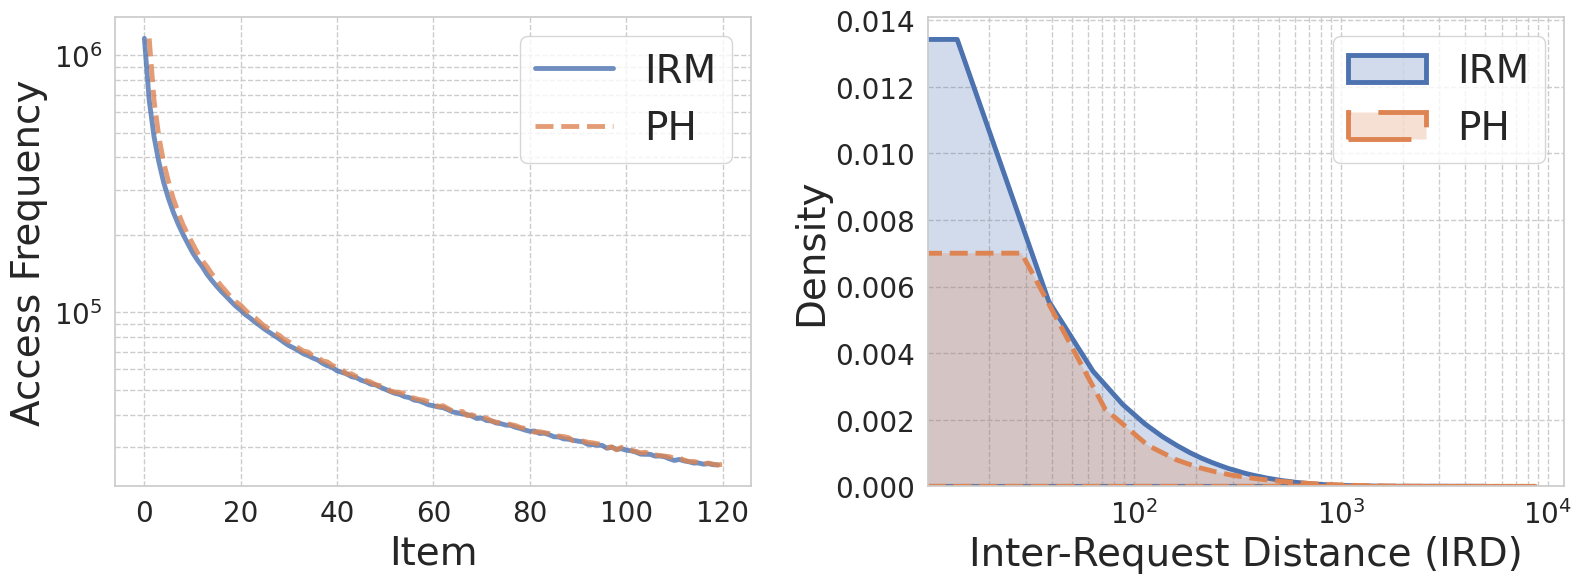

In [16]:
u1, c1 = np.unique(irm_08, return_counts=True)
u2, c2 = np.unique(ph_08, return_counts=True)

iads1 = tg.iad(irm_08)
iads1 = iads1[iads1 > 0]
iads2 = tg.iad(ph_08)
iads2 = iads2[iads2 > 0]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Access frequency
ax1.semilogy(u1, c1, label='IRM', lw=3.5, color=palette[0], alpha=0.8)
ax1.semilogy(u2, c2, label='PH', lw=3.5, color=palette[1], alpha=0.8, linestyle='--')
ax1.tick_params(axis='both', labelsize=20)
ax1.set_xlabel('Item', fontsize=28)
ax1.set_ylabel('Access Frequency', fontsize=28)
ax1.legend(fontsize=28)
ax1.grid(True, which="both", ls="--")

# IRD KDE
sns.kdeplot(iads1, bw_adjust=0.5, label='IRM', fill=True, ax=ax2, color=palette[0], common_norm=False, linewidth=3.5)
sns.kdeplot(iads2, bw_adjust=0.5, label='PH', fill=True, ax=ax2, color=palette[1], common_norm=False, linewidth=3.5, linestyle='--')
ax2.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax2.xaxis.get_major_formatter().set_scientific(True)
ax2.xaxis.get_major_formatter().set_powerlimits((-1, 1))
ax2.tick_params(axis='both', labelsize=20)
ax2.set_xscale('log')
ax2.set_xlabel('Inter-Request Distance (IRD)', fontsize=28)
ax2.set_ylabel('Density', fontsize=28)
ax2.legend(fontsize=28)
ax2.grid(True, which="both", ls="--")

plt.tight_layout()
plt.savefig('freqs_irds2.pdf', bbox_inches='tight', format='pdf')
plt.show()



In [11]:
# c1, hr_ran_clock1 = sim_ran_clock(irm_08, cnt=1)
# c16, hr_ran_clock16 = sim_ran_clock(irm_08, cnt=16)
# cl, hr_fifo_m = sim_fifo_m(irm_08)
# cr, hr_rand_m = sim_rand_m(irm_08)
# cc, hr_clock = sim_clock(irm_08, cnt=1)
# cc16, hr_clock16 = sim_clock(irm_08, cnt=16)
# cs, hr_sieve = sim_sieve(irm_08)

# cs08, hr_sieve08, c0816, hr_rc0816, cc08, hr_clock08, cl08fm, hr_fifo_m08, cr08, hr_rand_m08, cl08, hr_lru08, c081, hr_rc081, cf08, hr_fifo08 = np.load('data/mrcs_irm_08.npz', allow_pickle=True).values()

# cs11, hr_sieve11, c1116, hr_rc1116, cc11, hr_clock11, cl11fm, hr_fifo_m11, cr11, hr_rand_m11, cl11, hr_lru11, c111, hr_rc111, cf11, hr_fifo11 = np.load('data/mrcs_irm_11.npz',
#     allow_pickle=True).values()

cs16, hr_sieve16 = sim_sieve(irm_08, cnt=16)
# cl, hr_lru = sim_lru(irm_08)
# cf, hr_fifo = sim_fifo(irm_08)

plt.figure(figsize=(8,6))
ax = plt.gca()
ax.tick_params(axis='both', labelsize=20)
# ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
# ax.xaxis.get_major_formatter().set_scientific(True)
# ax.xaxis.get_major_formatter().set_powerlimits((-1, 1))
# ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
# ax.yaxis.get_major_formatter().set_scientific(True)
# ax.yaxis.get_major_formatter().set_powerlimits((-1, 1))
plt.plot(cs08[2:-5], hr_sieve08[2:-5], color=palette[0], marker='^', label='SIEVE K=1')
plt.plot(c0816[2:-5], hr_rc0816[2:-5], color=palette[6], marker='D', label='Ran-CLOCK K=16')
plt.plot(cc08[2:-5], hr_clock08[2:-5], color=palette[1], marker='o', label='CLOCK K=1')
plt.plot(cc16[2:-5], hr_clock16[2:-5], color=palette[9], marker='H', label='CLOCK K=16')
plt.plot(cl08fm[2:-5], hr_fifo_m08[2:-5], color=palette[7], marker='P', label='FIFO(m)')
plt.plot(cr08[2:-5], hr_rand_m08[2:-5], color=palette[4], marker='s', label='RAND(m)')
plt.plot(cl08[2:-5], hr_lru08[2:-5], color=palette[2], marker='v', label='LRU')
plt.plot(c081, hr_rc081, color=palette[3], marker='o', label='Ran-CLOCK K=1')
plt.plot(cf08, hr_fifo08, color=palette[5], marker='x', label='FIFO')
plt.xlabel('Cache Size C', fontsize=28)
plt.ylabel('Hit Rate', fontsize=28)
plt.legend(fontsize=16)
plt.title('IRM', fontsize=28)
plt.grid(True)
plt.savefig('mrcs_irm.pdf', bbox_inches='tight', format='pdf')
plt.show()

ValueError: too many values to unpack (expected 16)

In [ ]:
avgs = [
        ('SIEVE', np.mean(np.array(hr_sieve))),
        ('CLOCK K=1', np.mean(np.array(hr_clock))),
        ('LRU', np.mean(np.array(hr_lru))),
        ('Ran-CLOCK K=1', np.mean(np.array(hr_ran_clock1))),
        ('Ran-CLOCK K=16', np.mean(np.array(hr_ran_clock16))),
        ('RAND(m) m=[0.5C,0.5C]', np.mean(np.array(hr_rand_m))),
        ('FIFO(m) m=[0.5C,0.5C]', np.mean(np.array(hr_fifo_m))),
        ('FIFO', np.mean(np.array(hr_fifo))),
        ('CLOCK K=16', np.mean(np.array(hr_clock16))),
        ]
avgs.sort(key=lambda x: x[1], reverse=True)
print("IRM Average Hit Rates:")
for name, avg in avgs:
    print(f"{name}: {avg}")

In [ ]:
np.savez_compressed('data/mrcs_irm_08.npz',
    c_sieve=cs08, hr_sieve=hr_sieve08,
    c_sieve16=cs16, hr_sieve16=hr_sieve16,
    c_ran_clock16=c0816, hr_ran_clock16=hr_rc0816,
    c_clock=cc08, hr_clock=hr_clock08,
    c_fifo_m=cl08fm, hr_fifo_m=hr_fifo_m08,
    c_rand_m=cr08, hr_rand_m=hr_rand_m08,
    c_lru=cl08, hr_lru=hr_lru08,
    c_ran_clock1=c081, hr_ran_clock1=hr_rc081,
    c_fifo=cf08, hr_fifo=hr_fifo08
)

In [ ]:
np.savez_compressed('data/mrcs_irm_11.npz',
    c_sieve=cs11, hr_sieve=hr_sieve11,
    c_ran_clock16=c1116, hr_ran_clock16=hr_rc1116,
    c_clock=cc11, hr_clock=hr_clock11,
    c_fifo_m=cl11fm, hr_fifo_m=hr_fifo_m11,
    c_rand_m=cr11, hr_rand_m=hr_rand_m11,
    c_lru=cl11, hr_lru=hr_lru11,
    c_ran_clock1=c111, hr_ran_clock1=hr_rc111,
    c_fifo=cf11, hr_fifo=hr_fifo11
)

In [ ]:
che1, hr_he_ran_clock1 = sim_ran_clock(he2, cnt=1)
che16, hr_he_ran_clock16 = sim_ran_clock(he2, cnt=16)
cl_he, hr_he_fifo_m = sim_fifo_m(he2)
cr_he, hr_he_rand_m = sim_rand_m(he2)
cc_he1, hr_he_clock1 = sim_clock(he2, cnt=1)
cc_he16, hr_he_clock16 = sim_clock(he2, cnt=16)
cs_he, hr_he_sieve = sim_sieve(he2)
cl_he, hr_he_lru = sim_lru(he2)
cf_he, hr_he_fifo = sim_fifo(he2)
# cfq_he, hr_he_lfu = sim_lfu(he2)

# plt.figure(figsize=(8,6))
# ax = plt.gca()
# ax.tick_params(axis='both', labelsize=20)
# plt.plot(cl_he, hr_he_lru, color=palette[2], marker='v', label='LRU')
# plt.plot(cc_he1, hr_he_clock1, color=palette[1], marker='o', label='CLOCK K=1')
# plt.plot(cl_he, hr_he_fifo_m, color=palette[7], marker='P', label='FIFO(m) m=[0.5C,0.5C]')
# plt.plot(cf_he, hr_he_fifo, color=palette[5], marker='x', label='FIFO')
# plt.plot(che1, hr_he_ran_clock1, color=palette[3], marker='o', label='Ran-CLOCK K=1')
# plt.plot(cr_he, hr_he_rand_m, color=palette[4], marker='s', label='RAND(m) m=[0.5C,0.5C]')
# plt.plot(che16, hr_he_ran_clock16, color=palette[6], marker='D', label='Ran-CLOCK K=16')
# plt.plot(cs_he, hr_he_sieve, color=palette[0], marker='^', label='SIEVE')
# plt.plot(cfq_he, hr_he_lfu, color=palette[8], marker='*', label='LFU')

# plt.xlabel('Cache Size C', fontsize=28)
# plt.ylabel('Hit Rate', fontsize=28)
# plt.legend(fontsize=18)
# plt.title('HE', fontsize=28)
# plt.grid(True)
# plt.savefig('mrcs_he.pdf', bbox_inches='tight', format='pdf')
# plt.show()

# avgs2 = [('SIEVE', np.mean(np.array(hr_he_sieve))),
#          ('CLOCK', np.mean(np.array(hr_he_clock))),
#          ('LRU', np.mean(np.array(hr_he_lru))),
#          ('Ran-CLOCK K=1', np.mean(np.array(hr_he_ran_clock1))),
#          ('Ran-CLOCK K=16', np.mean(np.array(hr_he_ran_clock16))),
#          ('RAND(m) m=[0.5C,0.5C]', np.mean(np.array(hr_he_rand_m))),
#          ('FIFO(m) m=[0.5C,0.5C]', np.mean(np.array(hr_he_fifo_m))),
#          ('FIFO', np.mean(np.array(hr_he_fifo))),
#          ('LFU', np.mean(np.array(hr_he_lfu)))]
# avgs2.sort(key=lambda x: x[1], reverse=True)
# print("HE Average Hit Rates:")
# for name, avg in avgs2:
#     print(f"{name}: {avg}")

In [ ]:
cph1, hr_ph_ran_clock1 = sim_ran_clock(ph_08, cnt=1)
cph16, hr_ph_ran_clock16 = sim_ran_clock(ph_08, cnt=16)
cl_ph, hr_ph_fifo_m = sim_fifo_m(ph_08)
cr_ph, hr_ph_rand_m = sim_rand_m(ph_08)
cc_ph1, hr_ph_clock1 = sim_clock(ph_08, cnt=1)
cc_ph16, hr_ph_clock16 = sim_clock(ph_08, cnt=16)
cs_ph, hr_ph_sieve = sim_sieve(ph_08)
cl_ph, hr_ph_lru = sim_lru(ph_08)
cf_ph, hr_ph_fifo = sim_fifo(ph_08)

plt.figure(figsize=(8,6))
ax = plt.gca()
ax.tick_params(axis='both', labelsize=20)
plt.plot(cc_ph1[2:-5], hr_ph_clock1[2:-5], color=palette[1], marker='o', label='CLOCK K=1')
plt.plot(cc_ph16[2:-5], hr_ph_clock16[2:-5], color=palette[9], marker='H', label='CLOCK K=16')
plt.plot(cl_ph[2:-5], hr_ph_lru[2:-5], color=palette[2], marker='v', label='LRU')
plt.plot(cph16[2:-5], hr_ph_ran_clock16[2:-5], color=palette[6], marker='D', label='Ran-CLOCK K=16')
plt.plot(cl_ph[2:-5], hr_ph_fifo_m[2:-5], color=palette[7], marker='P', label='FIFO(m) m=[0.5C,0.5C]')
plt.plot(cs_ph[2:-5], hr_ph_sieve[2:-5], color=palette[0], marker='^', label='SIEVE')
plt.plot(cr_ph[2:-5], hr_ph_rand_m[2:-5], color=palette[4], marker='s', label='RAND(m) m=[0.5C,0.5C]')
plt.plot(cph1[2:-5], hr_ph_ran_clock1[2:-5], color=palette[3], marker='o', label='Ran-CLOCK K=1')
plt.plot(cf_ph[2:-5], hr_ph_fifo[2:-5], color=palette[5], marker='x', label='FIFO')
plt.xlabel('Cache Size C', fontsize=28)
plt.ylabel('Hit Rate', fontsize=28)
plt.legend(fontsize=16)
plt.title('PH', fontsize=28)
plt.grid(True)
plt.savefig('mrcs_ph.pdf', bbox_inches='tight', format='pdf')
plt.show()


In [ ]:
avgs2 = [('SIEVE', np.mean(np.array(hr_ph_sieve))),
         ('CLOCK K=1', np.mean(np.array(hr_ph_clock1))),
         ('CLOCK K=16', np.mean(np.array(hr_ph_clock16))),
         ('LRU', np.mean(np.array(hr_ph_lru))),
         ('Ran-CLOCK K=1', np.mean(np.array(hr_ph_ran_clock1))),
         ('Ran-CLOCK K=16', np.mean(np.array(hr_ph_ran_clock16))),
         ('RAND(m) m=[0.5C,0.5C]', np.mean(np.array(hr_ph_rand_m))),
         ('FIFO(m) m=[0.5C,0.5C]', np.mean(np.array(hr_ph_fifo_m))),
         ('FIFO', np.mean(np.array(hr_ph_fifo)))]
avgs2.sort(key=lambda x: x[1], reverse=True)
print("PH Average Hit Rates:")
for name, avg in avgs2:
    print(f"{name}: {avg}")


In [ ]:
policies = ["FIFO", "LRU", "CLOCK", "FIFO(m)", "Ran-CLOCK K=1", "RAND(m)", "Ran-CLOCK K=16", "SIEVE", "LFU"]
irm_hr = [hr_fifo, hr_lru, hr_clock, hr_fifo_m, hr_ran_clock1, hr_rand_m, hr_ran_clock16, hr_sieve, hr_lfu]
# he_hr  = [hr_he_fifo, hr_he_lru, hr_he_clock, hr_he_fifo_m, hr_he_ran_clock1, hr_he_rand_m, hr_he_ran_clock16, hr_he_sieve]
ph_hr  = [hr_ph_fifo, hr_ph_lru, hr_ph_clock, hr_ph_fifo_m, hr_ph_ran_clock1, hr_ph_rand_m, hr_ph_ran_clock16, hr_ph_sieve, hr_ph_lfu]
colors = [palette[5], palette[2], palette[1], palette[7], palette[3], palette[4], palette[6], palette[0], palette[8]]
markers = ['x', 'v', 'o', 'P', 'o', 's', 'D', '^', '*']
# linestyles = {'HE - IRM': '-', 'PH - IRM': ':'}
linestyles = {'PH - IRM': '-'}

c = cph1
rows = []
# for name, irm, he, ph in zip(policies, irm_hr, he_hr, ph_hr):
for name, irm, ph in zip(policies, irm_hr, ph_hr):
    irm = np.array(irm)
    # he  = np.array(he)
    ph  = np.array(ph)
    # deltas = [("HE - IRM", he - irm), ("PH - IRM", ph - irm)]
    deltas = [("PH - IRM", ph - irm)]
    for workload, delta in deltas:
        for C, d in zip(c, delta):
            rows.append({"C": C, "policy": name, "delta_hr": d, "workload": workload})

df_delta = pd.DataFrame(rows)
fig, ax = plt.subplots(figsize=(10,6))
ax.tick_params(axis='both', labelsize=20)
policy_handles, policy_labels = [], []
for name, color, marker in zip(policies, colors, markers):
    sub = df_delta[df_delta["policy"] == name]
    for workload, linestyle in linestyles.items():
        data = sub[sub["workload"] == workload]
        ax.plot(data["C"], data["delta_hr"], marker=marker, label=None, color=color, linestyle=linestyle, lw=3, markersize=7)
    policy_handles.append(Line2D([], [], color=color, marker=marker, linestyle="-", linewidth=3, markersize=10))
    policy_labels.append(name)

style_handles = [
    Line2D([], [], color='black', linestyle='-', linewidth=3),
    # Line2D([], [], color='black', linestyle='--', linewidth=3),
]
# style_labels = ['HE - IRM', 'PH - IRM']

fig.legend(policy_handles, policy_labels, loc='center left', bbox_to_anchor=(0.78, 0.60), ncol=1,
          fontsize=20, frameon=False, handlelength=1.0, handletextpad=0.6, columnspacing=0.8)
# fig.legend(style_handles, style_labels, loc='upper left', bbox_to_anchor=(0.78, 0.88), ncol=1,
        #   fontsize=20, frameon=False, handlelength=1.2, handletextpad=0.5, columnspacing=1.0)
ax.axhline(0, color='black', linewidth=2, linestyle='--')
ax.set_xlabel("Cache Size C", fontsize=28)
ax.set_ylabel("Hit Ratio Diffs vs IRM", fontsize=20)
ax.set_title("PH Performance Gains Relative to IRM", fontsize=20)
ax.grid(True)
fig.tight_layout(rect=[0, 0, 0.82, 1])
fig.savefig('mrcs_delta.pdf', bbox_inches='tight', format='pdf')
plt.show()


In [ ]:
avgs3 = [('SIEVE', np.mean(np.array(hr_ph_sieve) - np.array(hr_sieve))),
         ('CLOCK', np.mean(np.array(hr_ph_clock) - np.array(hr_clock))),
         ('LRU', np.mean(np.array(hr_ph_lru) - np.array(hr_lru))),
         ('Ran-CLOCK K=1', np.mean(np.array(hr_ph_ran_clock1) - np.array(hr_ran_clock1))),
         ('Ran-CLOCK K=16', np.mean(np.array(hr_ph_ran_clock16) - np.array(hr_ran_clock16))),
         ('RAND(m) m=[0.5C,0.5C]', np.mean(np.array(hr_ph_rand_m) - np.array(hr_rand_m))),
         ('FIFO(m) m=[0.5C,0.5C]', np.mean(np.array(hr_ph_fifo_m) - np.array(hr_fifo_m))),
         ('FIFO', np.mean(np.array(hr_ph_fifo) - np.array(hr_fifo))),
         ('LFU', np.mean(np.array(hr_ph_lfu) - np.array(hr_lfu)))]
avgs3.sort(key=lambda x: x[1], reverse=True)
print("Performance gains:")
for name, avg in avgs3:
    print(f"{name}: {avg}")

In [ ]:
# verify simulation for fifo(m) matches paper
trace = gen_from_zipf(300, 20000000, 0.8)[1]
hr1 = tg.sim_fifo_m([2, 98], trace)
hr2 = tg.sim_fifo_m([30, 70], trace)
hr3 = tg.sim_fifo_m([98, 2], trace)
print(1-hr1, 1-hr2, 1-hr3)
trace2 = gen_from_zipf(3000, 20000000, 0.8)[1]
hr11 = tg.sim_fifo_m([20, 980], trace2)
print(1-hr11)
hr22 = tg.sim_fifo_m([300, 700], trace2)
print(1-hr22)
hr33 = tg.sim_fifo_m([980, 20], trace2)
print(1-hr33)
trace3 = gen_from_zipf(300, 20000000, 1.1)[1]
hr111 = tg.sim_fifo_m([2, 98], trace3)
print(1-hr111)
hr222 = tg.sim_fifo_m([30, 70], trace3)
print(1-hr222)
hr333 = tg.sim_fifo_m([98, 2], trace3)
print(1-hr333)
hr1111 = tg.sim_fifo_m([2, 2, 96], trace)
print(1-hr1111)
hr2222 = tg.sim_fifo_m([10, 30, 60], trace)
print(1-hr2222)
hr3333 = tg.sim_fifo_m([20, 2, 78], trace)
print(1-hr3333)
hr4444 = tg.sim_fifo_m([90, 8, 2], trace)
print(1-hr4444)
hr5555 = tg.sim_fifo_m([1, 4, 10, 85], trace)
print(1-hr5555)
hr6666 = tg.sim_fifo_m([5, 15, 25, 55], trace)
print(1-hr6666)
hr7777 = tg.sim_fifo_m([25, 25, 25, 25], trace)
print(1-hr7777)
hr8888 = tg.sim_fifo_m([60, 2, 2, 36], trace)
print(1-hr8888)

In [ ]:
# verify simulation for rand(m) matches paper
trace = gen_from_zipf(300, 20000000, 0.8)[1]
hr1 = tg.sim_rand_m([2, 98], trace)
hr2 = tg.sim_rand_m([30, 70], trace)
hr3 = tg.sim_rand_m([98, 2], trace)
print(1-hr1, 1-hr2, 1-hr3)
trace2 = gen_from_zipf(3000, 20000000, 0.8)[1]
hr11 = tg.sim_rand_m([20, 980], trace2)
print(1-hr11)
hr22 = tg.sim_rand_m([300, 700], trace2)
print(1-hr22)
hr33 = tg.sim_rand_m([980, 20], trace2)
print(1-hr33)
trace3 = gen_from_zipf(300, 20000000, 1.1)[1]
hr111 = tg.sim_rand_m([2, 98], trace3)
print(1-hr111)
hr222 = tg.sim_rand_m([30, 70], trace3)
print(1-hr222)
hr333 = tg.sim_rand_m([98, 2], trace3)
print(1-hr333)
hr1111 = tg.sim_rand_m([2, 2, 96], trace)
print(1-hr1111)
hr2222 = tg.sim_rand_m([10, 30, 60], trace)
print(1-hr2222)
hr3333 = tg.sim_rand_m([20, 2, 78], trace)
print(1-hr3333)
hr4444 = tg.sim_rand_m([90, 8, 2], trace)
print(1-hr4444)
hr5555 = tg.sim_rand_m([1, 4, 10, 85], trace)
print(1-hr5555)
hr6666 = tg.sim_rand_m([5, 15, 25, 55], trace)
print(1-hr6666)
hr7777 = tg.sim_rand_m([25, 25, 25, 25], trace)
print(1-hr7777)
hr8888 = tg.sim_rand_m([60, 2, 2, 36], trace)
print(1-hr8888)

In [ ]:
# C = 60
# thetas = [0.5, 1.1]
# Ks = [1, 16]
# N_ITEMS = 120
# TRACE_LEN = 1000000
# X_MIN = 70
# HE_DASH = (0, (6, 3))
# MARKERS_PER_LINE = 80

# palette = sns.color_palette("deep", len(thetas) * len(Ks))
# color_map = {(theta, K): palette[i] for i, (theta, K) in enumerate((t, k) for t in thetas for k in Ks)}

# def run_curve(trace, K):
#     rc = tg.ran_clock(C=C, K=K)
#     _, _, examined, misses = rc.run_age(trace)
#     misses = np.cumsum(misses)
#     xs = np.arange(1, len(trace) + 1)
#     hr = misses / xs
#     mask = xs >= X_MIN
#     return xs[mask], hr[mask], np.asarray(examined)[mask]

# fig, ax = plt.subplots(figsize=(8, 6))
# combo_handles = []

# for theta in thetas:
#     trace_irm = gen_from_zipf(N_ITEMS, TRACE_LEN, theta)[1].astype(np.int32)
#     for K in Ks:
#         xs, hr, _ = run_curve(trace_irm, K)
#         ax.plot(xs, hr, lw=1.0, linestyle="-", color=color_map[(theta, K)], label=None)
#         combo_handles.append(Line2D([], [], color=color_map[(theta, K)], linestyle="-", lw=2.0))

# for theta in thetas:
#     trace_ph = gen_ph_2class(N_ITEMS, theta, TRACE_LEN, mu_ratio=10.0).astype(np.int32) - 1
#     for K in Ks:
#         xs, hr, _ = run_curve(trace_ph, K)
#         mark_count = min(len(xs), MARKERS_PER_LINE)
#         if len(xs) > 1:
#             log_positions = np.geomspace(xs[0], xs[-1], num=mark_count)
#             mark_indices = np.unique(np.searchsorted(xs, log_positions).clip(0, len(xs) - 1))
#         else:
#             mark_indices = np.array([0])
#         ax.plot(xs, hr, lw=1.0, linestyle=HE_DASH, color=color_map[(theta, K)], label=None,
#                 marker="+", markersize=8, markerfacecolor="white", markeredgewidth=1.0,
#                 markevery=mark_indices)

# for theta in thetas:
#     trace_he = gen_ph(N_ITEMS, theta, TRACE_LEN).astype(np.int32) - 1
#     for K in Ks:
#         xs, hr, _ = run_curve(trace_he, K)
#         mark_count = min(len(xs), MARKERS_PER_LINE)
#         if len(xs) > 1:
#             log_positions = np.geomspace(xs[0], xs[-1], num=mark_count)
#             mark_indices = np.unique(np.searchsorted(xs, log_positions).clip(0, len(xs) - 1))
#         else:
#             mark_indices = np.array([0])
#         ax.plot(xs, hr, lw=1.0, linestyle=HE_DASH, color=color_map[(theta, K)], label=None,
#                 marker="o", markersize=6, markerfacecolor="white", markeredgewidth=1.0,
#                 markevery=mark_indices)

# ax.tick_params(axis="both", labelsize=18)
# ax.set_xlabel("Number of requests", fontsize=28)
# ax.set_ylabel("Miss ratio", fontsize=28)
# ax.set_xscale("log")
# ax.set_xlim(left=X_MIN)
# ax.grid(True, alpha=0.3)

# labels = [f"θ={theta} K={K}" for theta in thetas for K in Ks]
# style_handles = [
#     Line2D([], [], color="black", linestyle="-", lw=2.0),
#     Line2D([], [], color="black", linestyle=HE_DASH, lw=2.0, marker="o", markersize=8, markerfacecolor="white", markeredgewidth=1.0),
#     Line2D([], [], color="black", linestyle=HE_DASH, lw=2.0, marker="+", markersize=8, markerfacecolor="white", markeredgewidth=1.0),
# ]

# ncol_param = len(labels)
# for h in combo_handles:
#     h.set_linewidth(5.0)
# fig.legend(handles=combo_handles, labels=labels,
#            loc="upper center", bbox_to_anchor=(0.5, 0.95), ncol=ncol_param,
#            fontsize=18, frameon=False, handlelength=0.6, handletextpad=0.5, columnspacing=1.0)

# fig.legend(handles=style_handles, labels=["IRM", "HE", "PH"],
#            loc="upper center", bbox_to_anchor=(0.5, 0.87), ncol=3,
#            fontsize=18, frameon=False, handlelength=0.8, handletextpad=0.5, columnspacing=1.5)

# fig.subplots_adjust(top=0.78)

# plt.savefig("ttf.pdf", bbox_inches="tight", format="pdf")
# plt.show()


In [ ]:

# # ks = [1, 8, 16, 32, 64, 128, 256]
# # mean_irm = np.empty(len(ks), dtype=float)
# # mean_ph = np.empty(len(ks), dtype=float)

# # for i, k in enumerate(ks):
# #     rc = tg.ran_clock(C=24, K=k)
# #     _, _, examined_irm_k, _ = rc.run_age(irm2)
# #     _, _, examined_ph_k, _ = rc.run_age(ph2)

# #     arr_irm = np.asarray(examined_irm_k, dtype=float)
# #     arr_ph = np.asarray(examined_ph_k, dtype=float)
# #     nz_irm = arr_irm > 0 
# #     nz_ph = arr_ph > 0

# #     mean_irm[i] = arr_irm[nz_irm].mean() if nz_irm.any() else 0.0
# #     mean_ph[i] = arr_ph[nz_ph].mean() if nz_ph.any() else 0.0

# fig, ax = plt.subplots(figsize=(8, 6))
# ax.plot(ks, mean_irm, marker='o', markersize=6, lw=3.5, label='IRM')
# ax.plot(ks, mean_ph, marker='o', markersize=6, lw=3.5, label='PH')
# ax.set_xscale("log", base=2)
# ax.set_xlabel("K", fontsize=28)
# ax.set_ylabel("Mean probes / eviction", fontsize=28)
# ax.tick_params(axis="both", labelsize=18)
# ax.legend(fontsize=28)
# ax.grid(True, alpha=0.3)
# plt.tight_layout()
# plt.savefig("mean_probes.pdf", bbox_inches="tight")
# plt.show()



In [ ]:
# k_values = [1, 16, 256, 65536]
# ns = [30, 60, 120, 240, 480, 960]

# means_irm = np.zeros((len(k_values), len(ns)), dtype=float)
# means_ph = np.zeros_like(means_irm)

# for ki, k in enumerate(k_values):
#     for ci, n in enumerate(ns):
#         trace_irm = gen_from_zipf(n, 1_000_000, 0.8)[1].astype(np.int32)
#         trace_ph = gen_ph_2class(n, 0.8, 1_000_000, mu_ratio=10.0).astype(np.int32)
#         c = max(1, n // 5)
#         rc = tg.ran_clock(C=c, K=k)
#         _, _, examined_irm_k, _ = rc.run_age(trace_irm)
#         _, _, examined_ph_k, _ = rc.run_age(trace_ph)

#         arr_irm = np.asarray(examined_irm_k, dtype=float)
#         arr_ph = np.asarray(examined_ph_k, dtype=float)
#         nz_irm = arr_irm > 0
#         nz_ph = arr_ph > 0

#         means_irm[ki, ci] = arr_irm[nz_irm].mean() if nz_irm.any() else 0.0
#         means_ph[ki, ci] = arr_ph[nz_ph].mean() if nz_ph.any() else 0.0     

# palette = sns.color_palette("deep", len(k_values))
# fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# handles = []
# for ax, means, title in [
#     (axes[0], means_irm, r"IRM"),
#     (axes[1], means_ph, r"PH"),
# ]:
#     for k, color, vals in zip(k_values, palette, means):
#         [line] = ax.plot(ns, vals, marker='o', markersize=6, lw=2.5, color=color, label=f"K={k}")
#         handles.append(line)
#     ax.set_title(title, fontsize=30)
#     ax.tick_params(axis="both", labelsize=20)
#     ax.grid(True, alpha=0.3)

# fig.legend(
#     handles=handles[:len(k_values)],
#     labels=[f"K={k}" for k in k_values],
#     loc="upper center",
#     ncol=len(k_values),
#     fontsize=20,
#     frameon=False, 
# )
# fig.supxlabel("n", fontsize=36)
# fig.supylabel("Mean probes / eviction", fontsize=28)
# plt.tight_layout(rect=(0, 0, 1, 0.92))
# plt.savefig("probe_vs_n.pdf", bbox_inches="tight", format="pdf")
# plt.show()


In [ ]:
# block io traces
w44 = np.loadtxt('/mnt/oldssd/opt/traces/w44_r.txt', dtype=np.int32)
w44[:, 0] += 7
w44 = tg.squash(tg.unroll(w44 // 8))

# rc_w44_c, rc_w44_hr = sim_ran_clock(w44, cnt=1)
# rc_w44_c16, rc_w44_hr16 = sim_ran_clock(w44, cnt=16)
# cc_w44_c, cc_w44_hr = sim_clock(w44)
# s_w44_c, sw44_hr = sim_sieve(w44)
# f_w44_c, fw44_hr = sim_fifo(w44)
# l_w44_c, lw44_hr = sim_lru(w44)
# fm_w44_c, fmw44_hr = sim_fifo_m(w44)
# rm_w44_c, rmw44_hr = sim_rand_m(w44)

# len(w44), len(set(w44))

In [ ]:
cc_w44_c16, cc_w44_hr16 = sim_clock(w44, cnt=16)
cc_w44_c1, cc_w44_hr1 = sim_clock(w44, cnt=1)
avgs_w44 = [('SIEVE', np.mean(np.array(sw44_hr))),
            ('CLOCK K=1', np.mean(np.array(cc_w44_hr1))),
            ('CLOCK K=16', np.mean(np.array(cc_w44_hr16))),
            ('Ran-CLOCK K=16', np.mean(np.array(rc_w44_hr16))),
            ('Ran-CLOCK K=1', np.mean(np.array(rc_w44_hr))),
            ('FIFO', np.mean(np.array(fw44_hr))),
            ('FIFO(m) m=[0.5C,0.5C]', np.mean(np.array(fmw44_hr))),
            ('RAND(m) m=[0.5C,0.5C]', np.mean(np.array(rmw44_hr))),
            ('LRU', np.mean(np.array(lw44_hr)))]
avgs_w44.sort(key=lambda x: x[1], reverse=True)
print("w44 Average Hit Rates:")
for name, avg in avgs_w44:
    print(f"{name}: {avg}") 


In [ ]:
# np.save('data/w44_mrcs.npy', {
#     'rc_c': rc_w44_c,
#     'rc_hr': rc_w44_hr,
#     'rc_c16': rc_w44_c16,
#     'rc_hr16': rc_w44_hr16,
#     'cc_c': cc_w44_c,
#     'cc_hr': cc_w44_hr,
#     'cc16_c': cc_w44_c16,
#     'cc_hr16': cc_w44_hr16,
#     's_c': s_w44_c,
#     's_hr': sw44_hr,
#     'f_c': f_w44_c,
#     'f_hr': fw44_hr,
#     'l_c': l_w44_c,
#     'l_hr': lw44_hr,
#     'fm_c': fm_w44_c,
#     'fm_hr': fmw44_hr,
#     'rm_c': rm_w44_c,
#     'rm_hr': rmw44_hr
# })

rc_w44_c, rc_w44_hr, rc_w44_c16, rc_w44_hr16, cc_w44_c, cc_w44_hr, cc_w44_c16, cc_w44_hr16, s_w44_c, sw44_hr, f_w44_c, fw44_hr, l_w44_c, lw44_hr, fm_w44_c, fmw44_hr, rm_w44_c, rmw44_hr = \
    

In [ ]:
plt.figure(figsize=(8,6))
ax = plt.gca()
ax.tick_params(axis='both', labelsize=20)
plt.plot(s_w44_c, sw44_hr, color=palette[0], marker='^', label='SIEVE')
plt.plot(rc_w44_c16, rc_w44_hr16, color=palette[6], marker='D', label='Ran-CLOCK K=16')
plt.plot(rc_w44_c, rc_w44_hr, color=palette[3], marker='o', label='Ran-CLOCK K=1')
plt.plot(cc_w44_c16, cc_w44_hr16, color=palette[9], marker='H', label='CLOCK K=16')
plt.plot(rm_w44_c, rmw44_hr, color=palette[4], marker='s', label='RAND(m)')
plt.plot(cc_w44_c1, cc_w44_hr1, color=palette[1], marker='o', label='CLOCK K=1')
plt.plot(f_w44_c, fw44_hr, color=palette[5], marker='x', label='FIFO')
plt.plot(l_w44_c, lw44_hr, color=palette[2], marker='v', label='LRU')
plt.plot(fm_w44_c, fmw44_hr, color=palette[7], marker='P', label='FIFO(m)')
plt.xlabel('Cache Size (4KB)', fontsize=28)
plt.ylabel('Block Hit Rate', fontsize=28)
plt.legend(fontsize=20, frameon=False, borderpad=0.0, labelspacing=0.2)
plt.title('CloudPhysics w44', fontsize=28)
plt.grid(True, alpha=0.3)
plt.savefig('mrcs_w44.pdf', bbox_inches='tight', format='pdf')
plt.show()

In [ ]:
w11 = np.loadtxt('/mnt/oldssd/opt/traces/w11_r.txt', dtype=np.int32)
w11[:, 0] += 7
w11 = tg.squash(tg.unroll(w11 // 8))

# rc_w11_c, rc_w11_hr = sim_ran_clock(w11, cnt=1)
# rc_w11_c16, rc_w11_hr16 = sim_ran_clock(w11, cnt=16)
# cc_w11_c, cc_w11_hr = sim_clock(w11)
# s_w11_c, sw11_hr = sim_sieve(w11)
# f_w11_c, fw11_hr = sim_fifo(w11)
# l_w11_c, lw11_hr = sim_lru(w11)
# fm_w11_c, fmw11_hr = sim_fifo_m(w11)
# rm_w11_c, rmw11_hr = sim_rand_m(w11)

# len(w11), len(set(w11))

In [ ]:
cc_w11_c16, cc_w11_hr16 = sim_clock(w11, cnt=16)
rc_w11_c, rc_w11_hr, rc_w11_c16, rc_w11_hr16, cc_w11_c, cc_w11_hr, s_w11_c, sw11_hr, f_w11_c, fw11_hr, l_w11_c, lw11_hr, fm_w11_c, fmw11_hr, rm_w11_c, rmw11_hr = \
    np.load('data/mrcs_w11.npz', allow_pickle=True).values()

np.savez_compressed('data/mrcs_w11.npz',
    rc_c=rc_w11_c,
    rc_hr=rc_w11_hr,
    rc_c16=rc_w11_c16,
    rc_hr16=rc_w11_hr16,
    cc_c=cc_w11_c,
    cc_hr=cc_w11_hr,
    cc16_c=cc_w11_c16,
    cc_hr16=cc_w11_hr16,
    s_c=s_w11_c,
    s_hr=sw11_hr,
    f_c=f_w11_c,
    f_hr=fw11_hr,
    l_c=l_w11_c,
    l_hr=lw11_hr,
    fm_c=fm_w11_c,
    fm_hr=fmw11_hr,
    rm_c=rm_w11_c,
    rm_hr=rmw11_hr
)

avegs_w11 = [('SIEVE', np.mean(np.array(sw11_hr))),
            ('CLOCK K=1', np.mean(np.array(cc_w11_hr))),
            ('CLOCK K=16', np.mean(np.array(cc_w11_hr16))),
            ('Ran-CLOCK K=16', np.mean(np.array(rc_w11_hr16))),
            ('Ran-CLOCK K=1', np.mean(np.array(rc_w11_hr))),
            ('FIFO', np.mean(np.array(fw11_hr))),
            ('FIFO(m)', np.mean(np.array(fmw11_hr))),
            ('RAND(m)', np.mean(np.array(rmw11_hr))),
            ('LRU', np.mean(np.array(lw11_hr)))]
avegs_w11.sort(key=lambda x: x[1], reverse=True)
print("w11 Average Hit Rates:")
for name, avg in avegs_w11:
    print(f"{name}: {avg}") 

In [ ]:
plt.figure(figsize=(8,6))
ax = plt.gca()
ax.tick_params(axis='both', labelsize=20)
plt.plot(cc_w11_c16, cc_w11_hr16, color=palette[9], marker='H', label='CLOCK K=16')
plt.plot(cc_w11_c, cc_w11_hr, color=palette[1], marker='o', label='CLOCK K=1')
plt.plot(l_w11_c, lw11_hr, color=palette[2], marker='v', label='LRU')
plt.plot(rc_w11_c16, rc_w11_hr16, color=palette[6], marker='D', label='Ran-CLOCK K=16')
plt.plot(fm_w11_c, fmw11_hr, color=palette[7], marker='P', label='FIFO(m)')
plt.plot(rc_w11_c, rc_w11_hr, color=palette[3], marker='o', label='Ran-CLOCK K=1')
plt.plot(rm_w11_c, rmw11_hr, color=palette[4], marker='s', label='RAND(m)')
plt.plot(f_w11_c, fw11_hr, color=palette[5], marker='x', label='FIFO')
plt.plot(s_w11_c, sw11_hr, color=palette[0], marker='^', label='SIEVE')

plt.xlabel('Cache Size (4KB)', fontsize=28)
plt.ylabel('Block Hit Rate', fontsize=28)
# ax.legend(fontsize=20, frameon=False, ncol=1, loc='lower right', columnspacing=0.2, handletextpad=0.2, borderpad=0.2, labelspacing=0.2)
plt.legend(fontsize=20, frameon=False, borderpad=0, labelspacing=0.2)
plt.grid(True, alpha=0.3)
plt.title('CloudPhysics w11', fontsize=28)
plt.savefig('mrcs_w11.pdf', bbox_inches='tight', format='pdf')
plt.show()

In [ ]:
v28 = np.loadtxt('/mnt/sda/alibaba_block_traces_2020/volume28.txt', dtype=np.int64)
v28[:, 0] += 4095
v28 = tg.squash(tg.unroll(v28 // 4096))

# len(v28), len(set(v28))
cc_v28_c16, cc_v28_hr16 = sim_clock(v28, cnt=16)
rc_v28_c, rc_v28_hr, rc_v28_c16, rc_v28_hr16, cc_v28_c, cc_v28_hr, s_v28_c, sv28_hr, f_v28_c, fv28_hr, l_v28_c, lv28_hr, fm_v28_c, fmv28_hr, rm_v28_c, rmv28_hr = \
    np.load('data/v28_mrcs.npz', allow_pickle=True).values()

In [ ]:
# rc_v28_c, rc_v28_hr = sim_ran_clock(v28, cnt=1)
# rc_v28_c16, rc_v28_hr16 = sim_ran_clock(v28, cnt=16)
# cc_v28_c, cc_v28_hr = sim_clock(v28)
# s_v28_c, sv28_hr = sim_sieve(v28)
# f_v28_c, fv28_hr = sim_fifo(v28)
# l_v28_c, lv28_hr = sim_lru(v28)
# fm_v28_c, fmv28_hr = sim_fifo_m(v28)
# rm_v28_c, rmv28_hr = sim_rand_m(v28)
avgs_v28 = [('SIEVE', np.mean(np.array(sv28_hr))),
                ('CLOCK K=16', np.mean(np.array(cc_v28_hr16))),
             ('CLOCK', np.mean(np.array(cc_v28_hr))),
             ('Ran-CLOCK K=16', np.mean(np.array(rc_v28_hr16))),
             ('Ran-CLOCK K=1', np.mean(np.array(rc_v28_hr))),
             ('FIFO', np.mean(np.array(fv28_hr))),
             ('FIFO(m) m=[0.5C,0.5C]', np.mean(np.array(fmv28_hr))),
             ('RAND(m) m=[0.5C,0.5C]', np.mean(np.array(rmv28_hr))),
             ('LRU', np.mean(np.array(lv28_hr)))]
avgs_v28.sort(key=lambda x: x[1], reverse=True)
print("v28 Average Hit Rates:")
for name, avg in avgs_v28:
    print(f"{name}: {avg}")

plt.figure(figsize=(8,6))
ax = plt.gca()
ax.tick_params(axis='both', labelsize=20)

plt.plot(rc_v28_c16, rc_v28_hr16, color=palette[6], marker='D', label='Ran-CLOCK K=16')
plt.plot(rc_v28_c, rc_v28_hr, color=palette[3], marker='o', label='Ran-CLOCK K=1')
plt.plot(s_v28_c, sv28_hr, color=palette[0], marker='^', label='SIEVE')
plt.plot(cc_v28_c16, cc_v28_hr16, color=palette[9], marker='H', label='CLOCK K=16')
plt.plot(cc_v28_c, cc_v28_hr, color=palette[1], marker='o', label='CLOCK K=1')
plt.plot(f_v28_c, fv28_hr, color=palette[5], marker='x', label='FIFO')
plt.plot(l_v28_c, lv28_hr, color=palette[2], marker='v', label='LRU')
plt.plot(rm_v28_c, rmv28_hr, color=palette[4], marker='s', label='RAND(m)')
plt.plot(fm_v28_c, fmv28_hr, color=palette[7], marker='P', label='FIFO(m)')

plt.xlabel('Cache Size (4KB)', fontsize=28)
plt.ylabel('Block Hit Rate', fontsize=28)
plt.legend(fontsize=20, frameon=False, borderpad=0.0, labelspacing=0.2)
plt.title('Alibaba volume28', fontsize=28)
plt.grid(True, alpha=0.3)
plt.savefig('mrcs_v28.pdf', bbox_inches='tight', format='pdf')
plt.show()


In [ ]:
np.savez_compressed('data/v28_mrcs.npz', 
    rc_c=rc_v28_c,
    rc_hr=rc_v28_hr,
    rc_c16=rc_v28_c16,
    rc_hr16=rc_v28_hr16,
    cc_c=cc_v28_c,
    cc_hr=cc_v28_hr,
    cc16_c=cc_v28_c16,
    cc_hr16=cc_v28_hr16,
    s_c=s_v28_c,
    s_hr=sv28_hr,
    f_c=f_v28_c,
    f_hr=fv28_hr,
    l_c=l_v28_c,
    l_hr=lv28_hr,
    fm_c=fm_v28_c,
    fm_hr=fmv28_hr,
    rm_c=rm_v28_c,
    rm_hr=rmv28_hr
)


In [ ]:
# V766 = np.loadtxt('/mnt/sda/alibaba_block_traces_2020/volume766.txt', dtype=np.int64)
# V766[:, 0] += 4095
# V766 = tg.squash(tg.unroll(V766 // 4096))

# # len(V766), len(set(V766))
# cc_V766_c16, cc_V766_hr16 = sim_clock(V766, cnt=16)

# rc_V766_c, rc_V766_hr, rc_V766_c16, rc_V766_hr16, cc_V766_c, cc_V766_hr, s_V766_c, sV766_hr, f_V766_c, fV766_hr, l_V766_c, lV766_hr, fm_V766_c, fmV766_hr, rm_V766_c, rmV766_hr = \
#     np.load('data/mrcs_v766.npz', allow_pickle=True).values()

# rc_V766_c, rc_V766_hr = sim_ran_clock(V766, cnt=1)
# rc_V766_c16, rc_V766_hr16 = sim_ran_clock(V766, cnt=16)
# cc_V766_c, cc_V766_hr = sim_clock(V766)
# s_V766_c, sV766_hr = sim_sieve(V766)
# f_V766_c, fV766_hr = sim_fifo(V766)
# l_V766_c, lV766_hr = sim_lru(V766)
# fm_V766_c, fmV766_hr = sim_fifo_m(V766)
# rm_V766_c, rmV766_hr = sim_rand_m(V766)

avgs_V766 = [('SIEVE', np.mean(np.array(sV766_hr))),
             ('CLOCK', np.mean(np.array(cc_V766_hr))),
                ('CLOCK K=16', np.mean(np.array(cc_V766_hr16))),
             ('Ran-CLOCK K=16', np.mean(np.array(rc_V766_hr16))),
             ('Ran-CLOCK K=1', np.mean(np.array(rc_V766_hr))),
             ('FIFO', np.mean(np.array(fV766_hr))),
             ('FIFO(m) m=[0.5C,0.5C]', np.mean(np.array(fmV766_hr))),
             ('RAND(m) m=[0.5C,0.5C]', np.mean(np.array(rmV766_hr))),
             ('LRU', np.mean(np.array(lV766_hr)))]
avgs_V766.sort(key=lambda x: x[1], reverse=True)
print("V766 Average Hit Rates:")
for name, avg in avgs_V766:
    print(f"{name}: {avg}")

In [ ]:
np.savez_compressed('data/mrcs_v766.npz',
    rc_c=rc_V766_c,
    rc_hr=rc_V766_hr,
    rc_c16=rc_V766_c16,
    rc_hr16=rc_V766_hr16,
    cc_c=cc_V766_c,
    cc_hr=cc_V766_hr,
    cc16_c=cc_V766_c16,
    cc_hr16=cc_V766_hr16,
    s_c=s_V766_c,
    s_hr=sV766_hr,
    f_c=f_V766_c,
    f_hr=fV766_hr,
    l_c=l_V766_c,
    l_hr=lV766_hr,
    fm_c=fm_V766_c,
    fm_hr=fmV766_hr,
    rm_c=rm_V766_c,
    rm_hr=rmV766_hr
)

In [ ]:
plt.figure(figsize=(8,6))
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.xaxis.get_major_formatter().set_scientific(True)
ax.xaxis.get_major_formatter().set_powerlimits((-1, 1))
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.tick_params(axis='both', labelsize=20)
plt.plot(s_V766_c, sV766_hr, color=palette[0], marker='^', label='SIEVE')
plt.plot(rc_V766_c16, rc_V766_hr16, color=palette[6], marker='D', label='Ran-CLOCK K=16')
plt.plot(rc_V766_c, rc_V766_hr, color=palette[3], marker='o', label='Ran-CLOCK K=1')
plt.plot(rm_V766_c, rmV766_hr, color=palette[4], marker='s', label='RAND(m)')
plt.plot(cc_V766_c16, cc_V766_hr16, color=palette[9], marker='H', label='CLOCK K=16')
plt.plot(cc_V766_c, cc_V766_hr, color=palette[1], marker='o', label='CLOCK K=1')
plt.plot(fm_V766_c, fmV766_hr, color=palette[7], marker='P', label='FIFO(m)')
plt.plot(f_V766_c, fV766_hr, color=palette[5], marker='x', label='FIFO')
plt.plot(l_V766_c, lV766_hr, color=palette[2], marker='v', label='LRU')

plt.xlabel('Cache Size (4KB)', fontsize=28)
plt.ylabel('Block Hit Rate', fontsize=28)
plt.legend(fontsize=20, frameon=False, borderpad=0.0, labelspacing=0.2)
plt.title('Alibaba volume766', fontsize=28)
plt.grid(True, alpha=0.3)
plt.savefig('mrcs_v766.pdf', bbox_inches='tight', format='pdf')
plt.show()

In [ ]:
# Meta CDN
import duckdb
con = duckdb.connect(':memory:')

result = con.execute("""
select *, regexp_extract(filename, '.*/([^/]+)\\.csv\\.zst', 1) as server
from read_csv(
    '/mnt/sda/metacdn/reag0c01_20230315_20230322_0.2000.csv.zst', 
    delim=',',
    header=true,
    filename=true,
    strict_mode=false
    )
limit 100
""")
result.df().tail()

In [ ]:
result = con.execute("""
select 
    count(*) as trace_length,
    count(distinct cacheKey) as unique_objects,
    avg(objectSize) as mean_object_size
from read_csv(
    '/mnt/sda/metacdn/reag0c01_20230315_20230322_0.2000.csv.zst', 
    delim=',',
    header=true,
    strict_mode=false
    )
""")
result.df()

In [ ]:
trace_path = '/mnt/sda/metacdn/reag0c01_20230315_20230322_0.2000.csv.zst'
out_path = '/mnt/sda/metacdn/keys_sizes.parquet'

key_size_query = f"""
select cacheKey, objectSize
from read_csv(
    '{trace_path}',
    delim=',',
    header=true,
    auto_detect=true,
    filename=false
)
"""
con.execute(f"COPY ({key_size_query}) TO '{out_path}' (FORMAT PARQUET);")


In [ ]:
parquet_path = '/mnt/sda/metacdn/keys_sizes.parquet'
max_rows = 10_000_000
bytes_per_unit = 65536
q = f"select cacheKey, objectSize from '{parquet_path}' limit {max_rows}"
cur = con.execute(q)

keys_parts, sizes_parts = [], []
while True:
    df = cur.fetch_df_chunk(1_000_000)
    if df.empty:
        break
    df = df[df.objectSize > 0]
    keys_parts.append(df['cacheKey'].reset_index(drop=True))
    sizes_parts.append(df['objectSize'].to_numpy(np.int64))

series = pd.concat(keys_parts, ignore_index=True)
key_ids, _ = pd.factorize(series, sort=False)
cdn_trc = key_ids.astype(np.int32)  # request-level trace

sizes = np.concatenate(sizes_parts)
lengths = np.maximum(1, (sizes + bytes_per_unit - 1) // bytes_per_unit).astype(np.int32)

len_addr = np.empty((len(lengths), 2), dtype=np.int32)
len_addr[:, 0] = lengths
len_addr[:, 1] = cdn_trc
cdn_trc_bytes = tg.squash(tg.unroll(len_addr)) 

In [ ]:
# arr = cdn_trc_bytes.astype(np.int32)  
# np.save("/mnt/sda/metacdn/cdn_trc_bytes.npy", arr)
# arr2 = cdn_trc.astype(np.int32)  
# np.save("/mnt/sda/metacdn/cdn_trc_keys.npy", arr2)

bytes_per_unit = 65536
c_bytes = [2**e for e in range(24, 34)]                 # 16MB .. 32GB
c_blocks = [cb // bytes_per_unit for cb in c_bytes]
xs_mb = [cb / 1024**2 for cb in c_bytes]
cdn_trc_bytes = np.load("/mnt/sda/metacdn/cdn_trc_bytes.npy").astype(np.int32)
cdn_trc = np.load("/mnt/sda/metacdn/cdn_trc_keys.npy").astype(np.int32)

In [ ]:

# hrs_rc1, hrs_rc16, hrs_clk, hrs_siv, hrs_fifo = [], [], [], [], []
# hrs_cc, hrs_lru, hrs_fm, hrs_rm = [], [], [], []
# xs_mb, hrs_siv, hrs_clk, hrs_rc1, hrs_rc16, hrs_fifo, hrs_lru, hrs_fm, hrs_rm = np.loadtxt('data/cdn_mrcs.txt').T.tolist()
# for cb, C in zip(c_bytes, c_blocks):
#     hrs_lru.append(tg.sim_lru(C, cdn_trc_bytes, raw=True))
#     hrs_fm.append(tg.sim_fifo_m([int(C)//2, int(C) - int(C)//2], cdn_trc_bytes))
#     hrs_rm.append(tg.sim_rand_m([int(C)//2, int(C) - int(C)//2], cdn_trc_bytes))
#     hrs_rc1.append(tg.sim_ran_clock(C, cdn_trc_bytes, raw=True, K=1))
#     hrs_rc16.append(tg.sim_ran_clock(C, cdn_trc_bytes, raw=True, K=16))
#     hrs_clk.append(tg.sim_clock(C, cdn_trc_bytes, raw=True))
#     hrs_siv.append(tg.sim_sieve(C, cdn_trc_bytes, raw=True))
#     hrs_fifo.append(tg.sim_fifo(C, cdn_trc_bytes, raw=True))

plt.figure(figsize=(8,6))
ax = plt.gca()
ax.tick_params(axis='both', labelsize=20)
# plt.plot(xs_mb, hrs_rm,   color=palette[4], marker='s', label='RAND(m) m=[0.5C,0.5C]')
plt.plot(xs_mb, hrs_rc1,  color=palette[3], marker='o', label='Ran-CLOCK K=1')
plt.plot(xs_mb, hrs_rc16, color=palette[6], marker='D', label='Ran-CLOCK K=16')
plt.plot(xs_mb, hrs_clk,  color=palette[1], marker='o', label='CLOCK')
plt.plot(xs_mb, hrs_lru,  color=palette[2], marker='v', label='LRU')
plt.plot(xs_mb, hrs_fifo, color=palette[5], marker='x', label='FIFO')
# plt.plot(xs_mb, hrs_fm, color=palette[7], marker='P', label='FIFO(m) m=[0.5C,0.5C]')
plt.plot(xs_mb, hrs_siv,  color=palette[0], marker='^', label='SIEVE')
plt.xscale('log', base=2)
plt.xlabel('Cache Size (MB)', fontsize=28)
plt.ylabel('Byte Hit Rate', fontsize=28)
plt.legend(fontsize=20, frameon=False, loc='upper left')
plt.title('metaCDN reag0c01', fontsize=28)
plt.grid(True)
plt.savefig('mrcs_cdn_bytes.pdf', bbox_inches='tight', format='pdf')
plt.show()

In [ ]:
avgs_cdn = [('SIEVE', np.mean(np.array(hrs_siv))),
             ('CLOCK', np.mean(np.array(hrs_clk))),
             ('Ran-CLOCK K=16', np.mean(np.array(hrs_rc16))),
             ('Ran-CLOCK K=1', np.mean(np.array(hrs_rc1))),
             ('FIFO', np.mean(np.array(hrs_fifo))),
             ('FIFO(m) m=[0.5C,0.5C]', np.mean(np.array(hrs_fm))),
             ('RAND(m) m=[0.5C,0.5C]', np.mean(np.array(hrs_rm))),
             ('LRU', np.mean(np.array(hrs_lru)))]
avgs_cdn.sort(key=lambda x: x[1], reverse=True)
print("metaCDN Average Hit Rates:")
for name, avg in avgs_cdn:
    print(f"{name}: {avg}")

In [ ]:
# np.savez_compressed('data/cdn_mrcs.npz',
#     xs_mb=xs_mb,
#     hrs_siv=hrs_siv,
#     hrs_clk=hrs_clk,
#     hrs_rc1=hrs_rc1,
#     hrs_rc16=hrs_rc16,
#     hrs_fifo=hrs_fifo,
#     hrs_lru=hrs_lru,
#     hrs_fm=hrs_fm,
#     hrs_rm=hrs_rm
# )
xs_mb, hrs_siv, hrs_clk, hrs_rc1, hrs_rc16, hrs_fifo, hrs_lru, hrs_fm, hrs_rm = \
    np.load('data/cdn_mrcs.npz', allow_pickle=True).values()

In [ ]:
# hrs_rq_rc1, hrs_rq_rc16, hrs_rq_clk, hrs_rq_siv, hrs_rq_fifo = [], [], [], [], []
# hrs_rq_lru, hrs_rq_fm, hrs_rq_rm = [], [], []
# for C in c_blocks:
#     hrs_rq_rc1.append(tg.sim_ran_clock(C, cdn_trc, raw=True, K=1))
#     hrs_rq_rc16.append(tg.sim_ran_clock(C, cdn_trc, raw=True, K=16))
#     hrs_rq_clk.append(tg.sim_clock(C, cdn_trc, raw=True))
#     hrs_rq_siv.append(tg.sim_sieve(C, cdn_trc, raw=True))
#     hrs_rq_fifo.append(tg.sim_fifo(C, cdn_trc, raw=True))
#     hrs_rq_lru.append(tg.sim_lru(C, cdn_trc, raw=True))
#     hrs_rq_fm.append(tg.sim_fifo_m([int(C)//2, int(C) - int(C)//2], cdn_trc))
#     hrs_rq_rm.append(tg.sim_rand_m([int(C)//2, int(C) - int(C)//2], cdn_trc))

plt.figure(figsize=(8,6))
ax = plt.gca()
ax.tick_params(axis='both', labelsize=20)
plt.plot(xs_mb, hrs_rq_siv,  color=palette[0], marker='^', label='SIEVE')
plt.plot(xs_mb, hrs_rq_clk,  color=palette[1], marker='o', label='CLOCK')
# plt.plot(xs_mb, hrs_rq_fm,   color=palette[7], marker='P', label='FIFO(m) m=[0.5C,0.5C]')
plt.plot(xs_mb, hrs_rq_rc16, color=palette[6], marker='D', label='Ran-CLOCK K=16')
plt.plot(xs_mb, hrs_rq_lru,  color=palette[2], marker='v', label='LRU')
plt.plot(xs_mb, hrs_rq_rc1,  color=palette[3], marker='o', label='Ran-CLOCK K=1')
# plt.plot(xs_mb, hrs_rq_rm,   color=palette[4], marker='s', label='RAND(m) m=[0.5C,0.5C]')
plt.plot(xs_mb, hrs_rq_fifo, color=palette[5], marker='x', label='FIFO')

# plt.xscale('log', base=2)
plt.xlabel('Cache Size (MB)', fontsize=28)
plt.ylabel('Request Hit Rate', fontsize=28)
plt.legend(fontsize=20, frameon=False)
plt.title('metaCDN reag0c01', fontsize=28)
plt.grid(True)
plt.savefig('mrcs_cdn_requests.pdf', bbox_inches='tight', format='pdf')
plt.show()


In [ ]:
# np.savez_compressed('data/cdn_req_mrcs.npz', 
#     xs_mb=xs_mb,
#     hrs_rq_siv=hrs_rq_siv,
#     hrs_rq_clk=hrs_rq_clk,
#     hrs_rq_rc1=hrs_rq_rc1,
#     hrs_rq_rc16=hrs_rq_rc16,
#     hrs_rq_fifo=hrs_rq_fifo,
#     hrs_rq_lru=hrs_rq_lru,
#     hrs_rq_fm=hrs_rq_fm,
#     hrs_rq_rm=hrs_rq_rm
# )

xs_mb, hrs_rq_siv, hrs_rq_clk, hrs_rq_rc1, hrs_rq_rc16, hrs_rq_fifo, hrs_rq_lru, hrs_rq_fm, hrs_rq_rm = \
    np.load('data/cdn_req_mrcs.npz', allow_pickle=True).values()

In [ ]:
avgs_cdn = [('SIEVE', np.mean(np.array(hrs_rq_siv))),
            ('CLOCK', np.mean(np.array(hrs_rq_clk))),
            ('Ran-CLOCK K=16', np.mean(np.array(hrs_rq_rc16 ))),
            ('Ran-CLOCK K=1', np.mean(np.array(hrs_rq_rc1 ))),
            ('FIFO', np.mean(np.array(hrs_rq_fifo))),
            ('FIFO(m) m=[0.5C,0.5C]', np.mean(np.array(hrs_rq_fm ))),
            ('RAND(m) m=[0.5C,0.5C]', np.mean(np.array(hrs_rq_rm ))),
            ('LRU', np.mean(np.array(hrs_rq_lru )))]
avgs_cdn.sort(key=lambda x: x[1], reverse=True)
print("metaCDN Average Hit Rates:")
for name, avg in avgs_cdn:
    print(f"{name}: {avg}")

In [ ]:
ks = [1, 16, 256, 65536]
thetas = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1]
cache_sizes = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
trace_len = 10_000_000
n_items = 1000
base_theta = 0.8
base_theta_idx = thetas.index(base_theta)

irm_traces = [gen_from_zipf(n_items, trace_len, theta)[1].astype(np.int32) for theta in thetas]
ph_traces = [gen_ph_2class(n_items, theta, trace_len).astype(np.int32) for theta in thetas]

run_rc = lambda C, trc, K: tg.sim_ran_clock(C, trc, raw=True, K=K)

C_theta = 300
hr_vs_theta_irm = {k: [run_rc(C_theta, trc, k) for trc in irm_traces] for k in ks}
hr_vs_theta_ph = {k: [run_rc(C_theta, trc, k) for trc in ph_traces] for k in ks}

irm_base = irm_traces[base_theta_idx]
ph_base = ph_traces[base_theta_idx]
hr_vs_C_irm = {k: [run_rc(C, irm_base, k) for C in cache_sizes] for k in ks}
hr_vs_C_ph = {k: [run_rc(C, ph_base, k) for C in cache_sizes] for k in ks}


colors = sns.color_palette("deep", len(ks))

theta_marker_positions = {}
cache_marker_positions = {}
for idx, k in enumerate(ks):
    theta_pos = [i for i in range(len(thetas)) if (i + idx) % 3 == 0]
    cache_pos = [i for i in range(len(cache_sizes)) if (i + idx) % 4 == 0]
    theta_marker_positions[k] = theta_pos or [0]
    cache_marker_positions[k] = cache_pos or [0]


def plot_family(title_prefix, hr_theta, hr_cache, outfile):
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=False)
    handles = []
    labels = []
    for k, color in zip(ks, colors):
        theta_marks = theta_marker_positions[k]
        cache_marks = cache_marker_positions[k]

        [line] = axes[0].plot(
            thetas,
            hr_theta[k],
            lw=3.0,
            color=color,
            linestyle="-",
            marker="o",
            markersize=12,
            markerfacecolor="white",
            markeredgecolor=color,
            markeredgewidth=1.5,
            markevery=theta_marks,
            label=None,
        )
        axes[1].plot(
            cache_sizes,
            hr_cache[k],
            lw=3.0,
            color=color,
            linestyle="-",
            marker="o",
            markersize=12,
            markerfacecolor="white",
            markeredgecolor=color,
            markeredgewidth=1.5,
            markevery=cache_marks,
            label=None,
        )
        handles.append(line)
        labels.append(f"K={k}")

    axes[0].set_xlabel("Parameter θ", fontsize=32)
    axes[0].set_ylabel("Hit Rate", fontsize=32)
    axes[0].tick_params(axis="both", labelsize=18)
    axes[0].grid(True, alpha=0.3)

    axes[1].set_xlabel("Cache Size C", fontsize=32)
    axes[1].set_ylabel("Hit Rate", fontsize=32)
    axes[1].tick_params(axis="both", labelsize=18)
    axes[1].grid(True, alpha=0.3)

    fig.legend(
        handles,
        labels,
        loc="upper center",
        bbox_to_anchor=(0.5, 1),
        ncol=len(labels),
        fontsize=32,
        frameon=False,
        handlelength=1.8,
        columnspacing=1.0,
    )
    fig.subplots_adjust(top=0.82, wspace=0.25)
    plt.savefig(outfile, bbox_inches='tight', format='pdf')
    plt.show()

plot_family("IRM", hr_vs_theta_irm, hr_vs_C_irm, 'rc_k_irm.pdf')
plot_family("PH", hr_vs_theta_ph, hr_vs_C_ph, 'rc_k_ph.pdf')


Plots saved as rc_k_irm.pdf and rc_k_ph.pdf.


In [9]:
def p_vec(theta, n):
    ranks = np.arange(1, n + 1, dtype=float)
    p = 1.0 / np.power(ranks, theta)
    p /= p.sum()
    return np.cumsum(p)

def ub_dist(cache_sizes, hit_rates, p):
    cache_sizes = np.asarray(cache_sizes, dtype=int)
    ub = p[cache_sizes-1]
    dist = np.asarray(hit_rates) - ub
    return dist

In [10]:

# c081, hr_rc081 = sim_ran_clock(irm_08, cnt=1)
# c0816, hr_rc0816 = sim_ran_clock(irm_08, cnt=16)
# cl08fm, hr_fifo_m08 = sim_fifo_m(irm_08)
# cr08, hr_rand_m08 = sim_rand_m(irm_08)
# cc08, hr_clock08 = sim_clock(irm_08)
# cc08_16, hr_clock08_16 = sim_clock(irm_08, cnt=16)
# cs08, hr_sieve08 = sim_sieve(irm_08)
# cl08, hr_lru08 = sim_lru(irm_08)
# cf08, hr_fifo08 = sim_fifo(irm_08)

# c111, hr_rc111 = sim_ran_clock(irm_11, cnt=1)
# c1116, hr_rc1116 = sim_ran_clock(irm_11, cnt=16)
# cl11fm, hr_fifo_m11 = sim_fifo_m(irm_11)
# cr11, hr_rand_m11 = sim_rand_m(irm_11)
# cc11, hr_clock11 = sim_clock(irm_11)
# cc11_16, hr_clock11_16 = sim_clock(irm_11, cnt=16)
# cs11, hr_sieve11 = sim_sieve(irm_11)
# cl11, hr_lru11 = sim_lru(irm_11)
# cf11, hr_fifo11 = sim_fifo(irm_11)

p08 = p_vec(theta=0.8, n=120)
p11 = p_vec(theta=1.1, n=120)

c081, hr_rc081, c0816, hr_rc0816, cl08fm, hr_fifo_m08, cr08, hr_rand_m08, cc08, hr_clock08, cc08_16, hr_clock08_16, cs08, hr_sieve08, cl08, hr_lru08, cf08, hr_fifo08 = \
    np.load('data/mrcs_irm_08.npz', allow_pickle=True).values()

# np.savez_compressed('data/mrcs_irm_08.npz',
#     c081=c081,
#     hr_rc081=hr_rc081,
#     c0816=c0816,
#     hr_rc0816=hr_rc0816,
#     cl08fm=cl08fm,
#     hr_fifo_m08=hr_fifo_m08,
#     cr08=cr08,
#     hr_rand_m08=hr_rand_m08,
#     cc08=cc08,
#     hr_clock08=hr_clock08,
#     cc08_16=cc08_16,
#     hr_clock08_16=hr_clock08_16,
#     cs08=cs08,
#     hr_sieve08=hr_sieve08,
#     cl08=cl08,
#     hr_lru08=hr_lru08,
#     cf08=cf08,
#     hr_fifo08=hr_fifo08
# )

c111, hr_rc111, c1116, hr_rc1116, cl11fm, hr_fifo_m11, cr11, hr_rand_m11, cc11, hr_clock11, cc11_16, hr_clock11_16, cs11, hr_sieve11, cl11, hr_lru11, cf11, hr_fifo11 = \
    np.load('data/mrcs_irm_11.npz', allow_pickle=True).values()

# np.savez_compressed('data/mrcs_irm_11.npz',
#     c111=c111,
#     hr_rc111=hr_rc111,
#     c1116=c1116,
#     hr_rc1116=hr_rc1116,
#     cl11fm=cl11fm,
#     hr_fifo_m11=hr_fifo_m11,
#     cr11=cr11,
#     hr_rand_m11=hr_rand_m11,
#     cc11=cc11,
#     hr_clock11=hr_clock11,
#     cc11_16=cc11_16,
#     hr_clock11_16=hr_clock11_16,
#     cs11=cs11,
#     hr_sieve11=hr_sieve11,
#     cl11=cl11,
#     hr_lru11=hr_lru11,
#     cf11=cf11,
#     hr_fifo11=hr_fifo11
# )

# c_ph_081, hr_ph_rc081 = sim_ran_clock(ph_08, cnt=1)
# c_ph_0816, hr_ph_rc0816 = sim_ran_clock(ph_08, cnt=16)
# cl_ph_08fm, hr_ph_fifo_m08 = sim_fifo_m(ph_08)
# cr_ph_08, hr_ph_rand_m08 = sim_rand_m(ph_08)
# cc_ph_08, hr_ph_clock08 = sim_clock(ph_08)
# cc_ph_08_16, hr_ph_clock08_16 = sim_clock(ph_08, cnt=16)
# cs_ph_08, hr_ph_sieve08 = sim_sieve(ph_08)
# cl_ph_08, hr_ph_lru08 = sim_lru(ph_08)
# cf_ph_08, hr_ph_fifo08 = sim_fifo(ph_08)

c_ph_081, hr_ph_rc081, c_ph_0816, hr_ph_rc0816, cl_ph_08fm, hr_ph_fifo_m08, cr_ph_08, hr_ph_rand_m08, cc_ph_08, hr_ph_clock08, cc_ph_08_16, hr_ph_clock08_16, cs_ph_08, hr_ph_sieve08, cl_ph_08, hr_ph_lru08, cf_ph_08, hr_ph_fifo08 = np.load('data/mrcs_ph_08.npz', allow_pickle=True).values()

# np.savez_compressed('data/mrcs_ph_08.npz',
#     c_ph_081=c_ph_081,
#     hr_ph_rc081=hr_ph_rc081,
#     c_ph_0816=c_ph_0816,
#     hr_ph_rc0816=hr_ph_rc0816,
#     cl_ph_08fm=cl_ph_08fm,
#     hr_ph_fifo_m08=hr_ph_fifo_m08,
#     cr_ph_08=cr_ph_08,
#     hr_ph_rand_m08=hr_ph_rand_m08,
#     cc_ph_08=cc_ph_08,
#     hr_ph_clock08=hr_ph_clock08,
#     cc_ph_0816=cc_ph_08_16,
#     hr_ph_clock08_16=hr_ph_clock08_16,
#     cs_ph_08=cs_ph_08,
#     hr_ph_sieve08=hr_ph_sieve08,
#     cl_ph_08=cl_ph_08,
#     hr_ph_lru08=hr_ph_lru08,
#     cf_ph_08=cf_ph_08,
#     hr_ph_fifo08=hr_ph_fifo08
# )

# c_ph_111, hr_ph_rc111 = sim_ran_clock(ph_11, cnt=1)
# c_ph_1116, hr_ph_rc1116 = sim_ran_clock(ph_11, cnt=16)
# cl_ph_11fm, hr_ph_fifo_m11 = sim_fifo_m(ph_11)
# cr_ph_11, hr_ph_rand_m11 = sim_rand_m(ph_11)
# cc_ph_11, hr_ph_clock11 = sim_clock(ph_11)
# cc_ph_11_16, hr_ph_clock11_16 = sim_clock(ph_11, cnt=16)
# cs_ph_11, hr_ph_sieve11 = sim_sieve(ph_11)
# cl_ph_11, hr_ph_lru11 = sim_lru(ph_11)
# cf_ph_11, hr_ph_fifo11 = sim_fifo(ph_11)

c_ph_111, hr_ph_rc111, c_ph_1116, hr_ph_rc1116, cl_ph_11fm, hr_ph_fifo_m11, cr_ph_11, hr_ph_rand_m11, cc_ph_11, hr_ph_clock11, cc_ph_11_16, hr_ph_clock11_16, cs_ph_11, hr_ph_sieve11, cl_ph_11, hr_ph_lru11, cf_ph_11, hr_ph_fifo11 = np.load('data/mrcs_ph_11.npz', allow_pickle=True).values()

# np.savez_compressed('data/mrcs_ph_11.npz',
#     c_ph_111=c_ph_111,
#     hr_ph_rc111=hr_ph_rc111,
#     c_ph_1116=c_ph_1116,
#     hr_ph_rc1116=hr_ph_rc1116,
#     cl_ph_11fm=cl_ph_11fm,
#     hr_ph_fifo_m11=hr_ph_fifo_m11,
#     cr_ph_11=cr_ph_11,
#     hr_ph_rand_m11=hr_ph_rand_m11,
#     cc_ph_11=cc_ph_11,
#     hr_ph_clock11=hr_ph_clock11,
#     cc_ph_11_16=cc_ph_11_16,
#     hr_ph_clock11_16=hr_ph_clock11_16,
#     cs_ph_11=cs_ph_11,
#     hr_ph_sieve11=hr_ph_sieve11,
#     cl_ph_11=cl_ph_11,
#     hr_ph_lru11=hr_ph_lru11,
#     cf_ph_11=cf_ph_11,
#     hr_ph_fifo11=hr_ph_fifo11
# )


In [16]:

dist_ph_08 = {
    'SIEVE': ub_dist(cs_ph_08, hr_ph_sieve08, p08),
    'Ran-CLOCK K=16': ub_dist(c_ph_0816, hr_ph_rc0816, p08),
    'CLOCK K=1': ub_dist(cc_ph_08, hr_ph_clock08, p08),
    'CLOCK K=16': ub_dist(cc_ph_08_16, hr_ph_clock08_16, p08),
    'FIFO(m)': ub_dist(cl_ph_08fm, hr_ph_fifo_m08, p08),
    'RAND(m)': ub_dist(cr_ph_08, hr_ph_rand_m08, p08),
    'LRU': ub_dist(cl_ph_08, hr_ph_lru08, p08),
    'Ran-CLOCK K=1': ub_dist(c_ph_081, hr_ph_rc081, p08),
    'FIFO': ub_dist(cf_ph_08, hr_ph_fifo08, p08),
}
entries_ph_08 = [
    ('CLOCK K=16', palette[9], 'H', cc_ph_08_16),
    ('RAND(m)', palette[4], 's', cr_ph_08),
    ('Ran-CLOCK K=1', palette[3], 'o', c_ph_081),
    ('Ran-CLOCK K=16', palette[6], 'D', c_ph_0816),
    ('CLOCK K=1', palette[1], 'o', cc_ph_08),
    ('LRU', palette[2], 'v', cl_ph_08),
    ('FIFO(m)', palette[7], 'P', cl_ph_08fm),
    ('SIEVE', palette[0], '^', cs_ph_08), 
    ('FIFO', palette[5], 'x', cf_ph_08),
    
]

dist_ph_11 = {
    'SIEVE': ub_dist(cs_ph_11, hr_ph_sieve11, p11),
    'Ran-CLOCK K=16': ub_dist(c_ph_1116, hr_ph_rc1116, p11),
    'CLOCK K=1': ub_dist(cc_ph_11, hr_ph_clock11, p11),
    'CLOCK K=16': ub_dist(cc_ph_11_16, hr_ph_clock11_16, p11),
    'FIFO(m)': ub_dist(cl_ph_11fm, hr_ph_fifo_m11, p11),
    'RAND(m)': ub_dist(cr_ph_11, hr_ph_rand_m11, p11),
    'LRU': ub_dist(cl_ph_11, hr_ph_lru11, p11),
    'Ran-CLOCK K=1': ub_dist(c_ph_111, hr_ph_rc111, p11),
    'FIFO': ub_dist(cf_ph_11, hr_ph_fifo11, p11),
}
entries_ph_11 = [
     ('CLOCK K=16', palette[9], 'H', cc_ph_11_16),
    ('Ran-CLOCK K=16', palette[6], 'D', c_ph_1116),
    ('RAND(m)', palette[4], 's', cr_ph_11),
    ('LRU', palette[2], 'v', cl_ph_11),
    ('Ran-CLOCK K=1', palette[3], 'o', c_ph_111),
    ('CLOCK K=1', palette[1], 'o', cc_ph_11),
    ('FIFO(m)', palette[7], 'P', cl_ph_11fm),
    ('SIEVE', palette[0], '^', cs_ph_11),   
    ('FIFO', palette[5], 'x', cf_ph_11),
   
]

dist_irm_08 = {
    'SIEVE': ub_dist(cs08, hr_sieve08, p08),
    'Ran-CLOCK K=16': ub_dist(c0816, hr_rc0816, p08),
    'CLOCK K=1': ub_dist(cc08, hr_clock08, p08),
    'CLOCK K=16': ub_dist(cc08_16, hr_clock08_16, p08),
    'FIFO(m)': ub_dist(cl08fm, hr_fifo_m08, p08),
    'RAND(m)': ub_dist(cr08, hr_rand_m08, p08),
    'LRU': ub_dist(cl08, hr_lru08, p08),
    'Ran-CLOCK K=1': ub_dist(c081, hr_rc081, p08),
    'FIFO': ub_dist(cf08, hr_fifo08, p08),
}

entries_irm_08 = [
    ('SIEVE', palette[0], '^', cs08),
    ('CLOCK K=16', palette[9], 'H', cc08_16),
    ('Ran-CLOCK K=16', palette[6], 'D', c0816), 
    ('CLOCK K=1', palette[1], 'o', cc08),
    ('RAND(m)', palette[4], 's', cr08),
    ('FIFO(m)', palette[7], 'P', cl08fm),
    ('LRU', palette[2], 'v', cl08),
    ('Ran-CLOCK K=1', palette[3], 'o', c081),
    ('FIFO', palette[5], 'x', cf08),
    
]

dist_irm_11 = {
    'SIEVE': ub_dist(cs11, hr_sieve11, p11),
    'Ran-CLOCK K=16': ub_dist(c1116, hr_rc1116, p11),
    'CLOCK K=1': ub_dist(cc11, hr_clock11, p11),
    'CLOCK K=16': ub_dist(cc11_16, hr_clock11_16, p11),
    'FIFO(m)': ub_dist(cl11fm, hr_fifo_m11, p11),
    'RAND(m)': ub_dist(cr11, hr_rand_m11, p11),
    'LRU': ub_dist(cl11, hr_lru11, p11),
    'Ran-CLOCK K=1': ub_dist(c111, hr_rc111, p11),
    'FIFO': ub_dist(cf11, hr_fifo11, p11),
}

entries_irm_11 = [
    ('SIEVE', palette[0], '^', cs11),
    ('CLOCK K=16', palette[9], 'H', cc11_16),
    ('Ran-CLOCK K=16', palette[6], 'D', c1116), 
    ('CLOCK K=1', palette[1], 'o', cc11),
    ('RAND(m)', palette[4], 's', cr11),
    ('FIFO(m)', palette[7], 'P', cl11fm),
    ('LRU', palette[2], 'v', cl11),
    ('Ran-CLOCK K=1', palette[3], 'o', c111),
    ('FIFO', palette[5], 'x', cf11),  
]



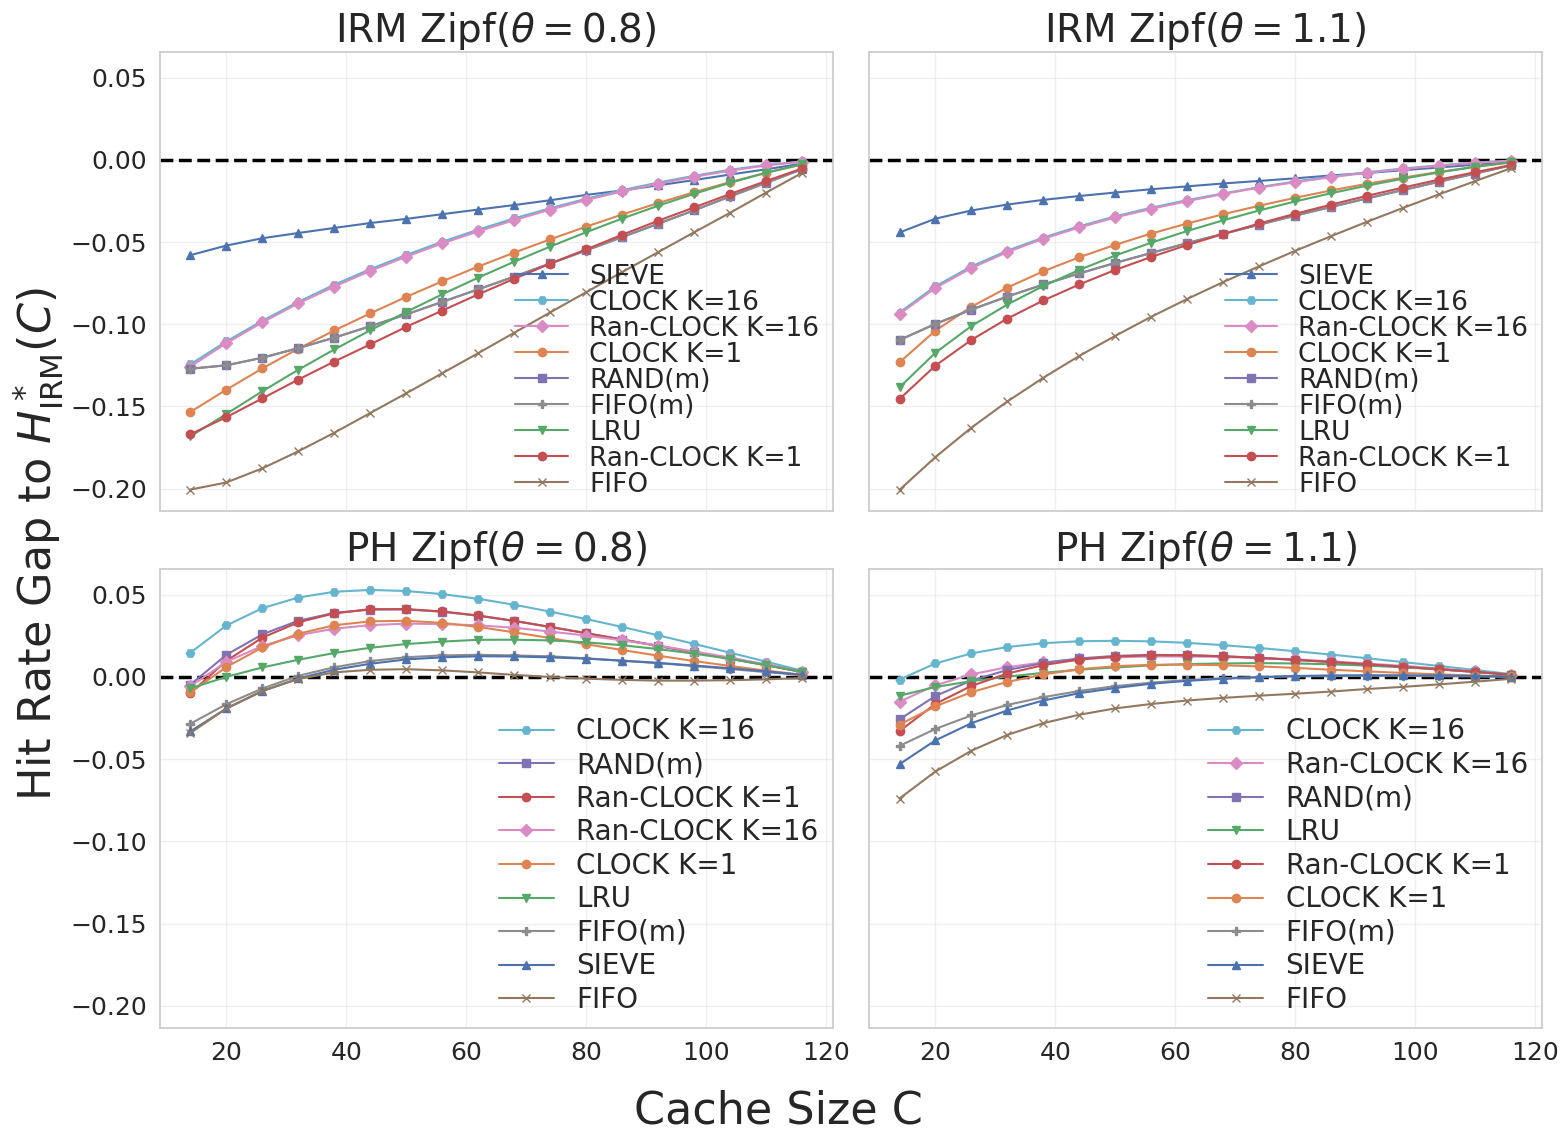

In [17]:

fig, axes = plt.subplots(2, 2, figsize=(16, 12), sharex=True, sharey=True)
(ax_irm08, ax_irm11), (ax_ph08, ax_ph11) = axes

def style_ax(ax, title):
    ax.tick_params(axis='both', labelsize=18)
    ax.axhline(0, color='black', linestyle='--', linewidth=2.5)
    ax.set_title(title, fontsize=28)
    ax.grid(True)

style_ax(ax_ph08, 'PH Zipf($\\theta = 0.8$)')
style_ax(ax_ph11, 'PH Zipf($\\theta = 1.1$)')
style_ax(ax_irm08, 'IRM Zipf($\\theta = 0.8$)')
style_ax(ax_irm11, 'IRM Zipf($\\theta = 1.1$)')


for key, color, marker, c_vals in entries_irm_08:
    abs_dist = dist_irm_08[key]
    ax_irm08.plot(c_vals[2:], abs_dist[2:], marker=marker, label=key, color=color)
ax_irm08.legend(fontsize=19, frameon=False, borderpad=0.0, labelspacing=0.0)
ax_irm08.grid(True, alpha=0.3)

for key, color, marker, c_vals in entries_irm_11:
    abs_dist = dist_irm_11[key]
    ax_irm11.plot(c_vals[2:], abs_dist[2:], marker=marker, label=key, color=color)
ax_irm11.legend(fontsize=19, frameon=False, borderpad=0.0, labelspacing=0.0)
ax_irm11.grid(True, alpha=0.3)

for key, color, marker, c_vals in entries_ph_08:
    abs_dist = dist_ph_08[key]
    ax_ph08.plot(c_vals[2:], abs_dist[2:], marker=marker, label=key, color=color)
ax_ph08.legend(fontsize=20, frameon=False, borderpad=0.0, labelspacing=0.2, loc = 'lower right')
ax_ph08.grid(True, alpha=0.3)

for key, color, marker, c_vals in entries_ph_11:
    abs_dist = dist_ph_11[key]
    ax_ph11.plot(c_vals[2:], abs_dist[2:], marker=marker, label=key, color=color)
ax_ph11.legend(fontsize=20, frameon=False, borderpad=0.0, labelspacing=0.2, loc = 'lower right')
ax_ph11.grid(True, alpha=0.3)

fig.supxlabel('Cache Size C', fontsize=32)
fig.supylabel('Hit Rate Gap to $H^*_{\mathrm{IRM}}(C)$', fontsize=32)
fig.tight_layout(rect=[0, 0, 1, 0.96])
fig.savefig('mrcs_ph_irm_dist_combined.pdf', bbox_inches='tight', format='pdf')
plt.show()



In [15]:
avgs_irm_08 = [(name, np.mean(ub_dist)) for name, ub_dist in dist_irm_08.items()]
avgs_irm_08.sort(key=lambda x: x[1], reverse=True)
print("IRM θ=0.8 Average Gaps to Optimal:")
for name, avg in avgs_irm_08:
    print(f"{name}: {avg}")

print()
avgs_irm_11 = [(name, np.mean(ub_dist)) for name, ub_dist in dist_irm_11.items()]
avgs_irm_11.sort(key=lambda x: x[1], reverse=True)
print("IRM θ=1.1 Average Gaps to Optimal:")
for name, avg in avgs_irm_11:
    print(f"{name}: {avg}")
print()
avgs_ph_08 = [(name, np.mean(ub_dist)) for name, ub_dist in dist_ph_08.items()]
avgs_ph_08.sort(key=lambda x: x[1], reverse=True)
print("PH θ=0.8 Average Gaps to Optimal:")
for name, avg in avgs_ph_08:
    print(f"{name}: {avg}")
print()
avgs_ph_11 = [(name, np.mean(ub_dist)) for name, ub_dist in dist_ph_11.items()]
avgs_ph_11.sort(key=lambda x: x[1], reverse=True)
print("PH θ=1.1 Average Gaps to Optimal:")
for name, avg in avgs_ph_11:
    print(f"{name}: {avg}")

IRM θ=0.8 Average Gaps to Optimal:
SIEVE: -0.03556564922401031
CLOCK K=16: -0.05579302422401029
Ran-CLOCK K=16: -0.05667235422401029
CLOCK K=1: -0.07460330422401032
RAND(m): -0.07569495922401029
FIFO(m): -0.07570552922401033
LRU: -0.0812295542240103
Ran-CLOCK K=1: -0.08742136922401031
FIFO: -0.11488854922401029

IRM θ=1.1 Average Gaps to Optimal:
SIEVE: -0.027850233897577154
CLOCK K=16: -0.041983948897577124
Ran-CLOCK K=16: -0.04257416889757713
CLOCK K=1: -0.05679589889757715
RAND(m): -0.057413968897577126
FIFO(m): -0.05743039889757713
LRU: -0.06270236889757715
Ran-CLOCK K=1: -0.06902375889757714
FIFO: -0.09968744389757714

PH θ=0.8 Average Gaps to Optimal:
CLOCK K=16: 0.027717470775989683
RAND(m): 0.017880785775989696
Ran-CLOCK K=1: 0.01698413077598969
Ran-CLOCK K=16: 0.014281290775989688
CLOCK K=1: 0.012817445775989686
LRU: 0.008777695775989683
FIFO(m): -0.0004343792240102978
SIEVE: -0.002395194224010308
FIFO: -0.008072989224010304

PH θ=1.1 Average Gaps to Optimal:
CLOCK K=16: 0.007